1. Import necessary libraries and PORT-EK source code:

In [32]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib
import pickle
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from Bio import SeqIO, Align, Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
from matplotlib import colormaps
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.stats import pearsonr
from datetime import datetime
from sklearn.decomposition import PCA
#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True
print(os.getpid())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2498613


2. Declare data set specific definitions and functions:

In [33]:
# PORT-EK parameters
k = 11  # This is the length of k-mers
c = 0.19  # This is the conservation thershold used in k-mer rarity filter
m = 1  # This is the maximum number of mismatches allowed when re-examining rare k-mers
min_RMSE = 0.5  # This is the RMSE threshold used to select enriched k-mers

# Relative path to k-mer indices
INPUT_PATH = "../output/HIV/scenario4"

# Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.
SAMPLE_GROUPS = ["M", "nonM"]
SAMPLE_SUBTYPES = ["MA", "MB", "MC", "MD", "Mrest", "N", "O", "P"]

FREQ_COLS = [f"{group}_freq" for group in SAMPLE_GROUPS]
SUB_FREQ_COLS = [f"{group}_freq" for group in SAMPLE_SUBTYPES]

AVG_COLS = [f"{group}_avg" for group in SAMPLE_GROUPS]
SUB_AVG_COLS = [f"{group}_avg" for group in SAMPLE_SUBTYPES]

VOLCANO_CMAP = {
    "not_significant": ("#DDDDDD", 0.5),
    "M_enriched": ("#ffa401", 1),
    "nonM_enriched": ("#005ff5", 1),
}

HIV_GENES = {
    "5' LTR": [(1, 634)],
    "gag": [(789, 2289)],
    "pol": [(2084, 5093)],
    "vif": [(5040, 5616)],
    "vpr": [(5558, 5846)],
    "tat": [(5830, 6045), (8378, 8466)],
    "rev": [(5969, 6045), (8378, 8650)],
    "vpu": [(6061,6307)],
    "env": [(6224, 8792)],
    "nef": [(8796, 9414)],
    "3' LTR": [(9086, 9719)],
}

ref_seq = SeqIO.read("../input/HXB2.fasta", format="fasta").seq
aligner = Align.PairwiseAligner(
    # match_score=5,
    # mismatch_score=-4,
    # open_gap_score=-10,
    # extend_gap_score=-0.5,
    scoring="megablast",
    mode="local"
)


def assign_gene_from_interval(ref_pos: list, gene_dict: dict) -> str:
    genes = []
    for start, end in ref_pos:
        for gene, gene_ranges in gene_dict.items():
            for gene_range in gene_ranges:
                if (
                    len(
                        [
                            pos
                            for pos in range(start, end + 1)
                            if pos in list(range(gene_range[0], gene_range[1] + 1))
                        ]
                    )
                    > 0
                ):
                    genes.append(gene)

    return ", ".join(genes)

def assign_gene_from_position(ref_pos: int, gene_dict: dict) -> str:
    genes = []
    for gene, gene_ranges in gene_dict.items():
        for gene_range in gene_ranges:
            if gene_range[0] < ref_pos < gene_range[1]:
                genes.append(gene)
    return ", ".join(genes)

3. Load enriched k-mer matrix

In [34]:
kmer_set = set()
sample_list = []
kmer_set_in_path = pathlib.Path(INPUT_PATH).glob(f"*{k}mer_set.pkl")
sample_list_in_path = pathlib.Path(INPUT_PATH).glob("*sample_list.pkl")

for filename in kmer_set_in_path:
    with open(filename, mode="rb") as in_file:
        partial_set = pickle.load(in_file)
    kmer_set.update(partial_set)

for filename in sample_list_in_path:
    with open(filename, mode="rb") as in_file:
        partial_list = pickle.load(in_file)
    group = filename.stem.split("_")[0]
    partial_list = [f"{group}_{sample_name}" for sample_name in partial_list]
    sample_list.extend(partial_list)
sample_list.sort()

subtype_sample_idx = {f"{subtype}": [sample for sample in sample_list if sample.split("_")[0] == f"{subtype}"] for subtype in SAMPLE_SUBTYPES}
group_sample_idx = {f"{group}":[] for group in SAMPLE_GROUPS}
for sample in sample_list:
    if "M" in sample.split("_")[0]:
        group_sample_idx["M"].append(sample)
    else:
        group_sample_idx["nonM"].append(sample)
print(f"\nImported {len(kmer_set)} kmers and {len(sample_list)} samples.")

enriched_kmer_matrix = pd.read_csv(f"../output/HIV/scenario4/enriched_{k}mer_count_matrix.csv", index_col=0)
subB_enriched_matrix = pd.read_csv(f"../output/HIV/subB/aligned_enriched_{k}mer_stat_matrix.csv", index_col=0)
enriched_kmer_matrix["B_group"] = subB_enriched_matrix["group"]
enriched_kmer_matrix


Imported 1240578 kmers and 15295 samples.


/tmp/ipykernel_2498613/3445299951.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  enriched_kmer_matrix["B_group"] = subB_enriched_matrix["group"]


,MA_A.CD.1987.P4039.MH705157,MA_A.CH.2003.HIV_CH_BID-V3538_2003.JQ403028,MA_A.ZA.2004.04ZASK162B1.DQ396400,MA_A1.AU.2003.PS1044_Day0.DQ676872,MA_A1.AU.2004.PS1044_Day177.DQ676873,MA_A1.BG.2009.V_09_007.MH746259,MA_A1.BG.2009.V_09_008.MH746258,MA_A1.BG.2009.V_09_017.MH746253,MA_A1.CD.1987.2106.MH705158,MA_A1.CD.1987.70641.MH705151,...,M_avg,nonM_freq,nonM_avg,M-nonM_err,M-nonM_p-value,-log10_M-nonM_p-value,RMSE,group,exclusivity,B_group
GAAAAAATAGA,0,0,0,0,0,0,0,0,0,0,...,0.034227,0.986301,1.712329,-1.678102,2.932372e-27,26.532781,1.678102,nonM_enriched,non-exclusive,NaN
GGAATTGGAGG,1,1,1,1,1,1,1,2,1,2,...,1.759033,0.164384,0.164384,1.594649,3.486212e-51,50.457646,1.594649,M_enriched,non-exclusive,NaN
TGCTGACACTG,0,0,0,0,0,0,0,0,0,0,...,0.070096,0.780822,1.534247,-1.464151,1.612715e-10,9.792442,1.464151,nonM_enriched,non-exclusive,NaN
GACTTTCCAGC,0,0,0,0,0,0,0,0,0,0,...,0.000263,0.630137,1.301370,-1.301107,8.793383e-37,36.055844,1.301107,nonM_enriched,non-exclusive,NaN
AAAACAAATTA,1,1,1,0,0,1,1,1,1,0,...,1.266128,0.000000,0.000000,1.266128,1.875678e-54,53.726842,1.266128,M_enriched,exclusive,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AATTTGCTGAG,0,0,1,1,1,1,1,1,1,0,...,0.500197,0.000000,0.000000,0.500197,1.873258e-22,21.727402,0.500197,M_enriched,exclusive,NaN
AGTTAATAAAA,0,0,0,0,0,0,0,0,0,0,...,0.500197,0.000000,0.000000,0.500197,1.929694e-22,21.714511,0.500197,M_enriched,exclusive,NaN
AGCACTAACAG,1,0,0,1,1,2,2,1,0,1,...,0.609644,0.109589,0.109589,0.500055,2.507847e-18,17.600699,0.500055,M_enriched,non-exclusive,Bmain_enriched
TCAGGACAATA,0,0,0,0,0,0,0,0,0,0,...,0.006832,0.506849,0.506849,-0.500017,1.963172e-57,56.707042,0.500017,nonM_enriched,non-exclusive,NaN


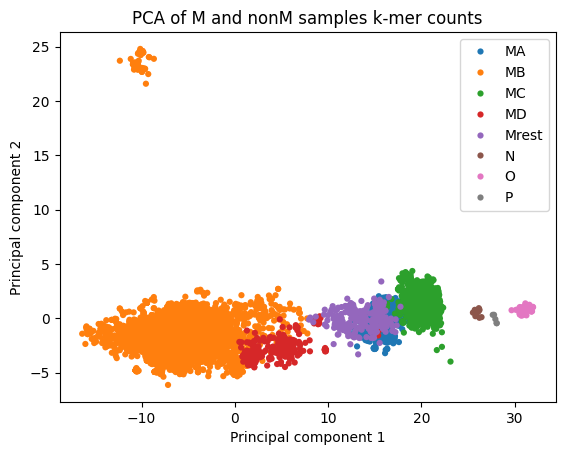

In [35]:
#Perform and plot PCA 
y_names = [name.split("_")[0] for name in sample_list]

pca = PCA(2)
X_pca = pd.DataFrame(pca.fit_transform(enriched_kmer_matrix[sample_list].T), index=sample_list)
fig, ax = plt.subplots()
ax.set_title('PCA of M and nonM samples k-mer counts')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
sns.scatterplot(x=X_pca[0], y=X_pca[1], hue=y_names, s=20, linewidth = 0)

#Uncomment the following line to save the plot as svg.
plt.savefig("../output/HIV/scenario4/PCA.svg", dpi = 600, format = "svg", bbox_inches='tight')

Identify B outliers

In [36]:
B_outliers = X_pca[X_pca[1] > 15].index.to_list()
subtype_sample_idx["MB"] = [sample for sample in subtype_sample_idx["MB"] if sample not in B_outliers]
subtype_sample_idx["MB_out"] = B_outliers

In [51]:
set([name.split(".")[3][:4] for name in B_outliers])

{'605_', '9252'}

In [54]:
[name for name in subtype_sample_idx["MB"] if "605" in name]

['MB_B.AU.2006.P6_PBMC_BSL_88.OK532605',
 'MB_B.CA.2016.ART1_87E5_92C0P0_494.ON816050',
 'MB_B.CA.2016.ART1_87F3_13C0P1_146.ON816051',
 'MB_B.CA.2016.ART1_93A11_33C0P0_481.ON816056',
 'MB_B.CA.2016.ART1_93A12_34C0P0_490.ON816057',
 'MB_B.CA.2016.ART1_93A3_29C0P0_482.ON816052',
 'MB_B.CA.2016.ART1_93A4_30C1P1_318.ON816053',
 'MB_B.CA.2016.ART1_93A5_31C0P0_473.ON816054',
 'MB_B.CA.2016.ART1_93A8_32C0P0_486.ON816055',
 'MB_B.CA.2016.ART1_93B4_35C0P0_472.ON816058',
 'MB_B.CA.2016.ART1_93C4_39C0P0_492.ON816059',
 'MB_B.CA.2018.ART3_R2p3C11_Barcode84--84_Cluster0_Phase0.MZ662605',
 'MB_B.CN.2009.09LNA014.JX960597',
 'MB_B.CN.2009.09LNA336.JX960599',
 'MB_B.CN.2009.09LNA439.JX960598',
 'MB_B.DE.2016.9254_W12_5M5_S77.MK116052',
 'MB_B.DE.2016.9254_W12_5N1_S79.MK116053',
 'MB_B.DE.2016.9254_W12_5N20_S81.MK116054',
 'MB_B.DE.2016.9254_W12_5N2_S80.MK116055',
 'MB_B.DE.2016.9254_W12_5P22_S85.MK116057',
 'MB_B.DE.2016.9254_W12_5P6_S84.MK116058',
 'MB_B.DE.2016.9254_W12_6A4_S86.MK116059',
 'MB_B.GB.

Subsample sample list

In [37]:
k = 100
subsampled_subtype_sample_idx = {}
for subtype, sample_names in subtype_sample_idx.items():
    if len(sample_names) <= k:
        subsampled_subtype_sample_idx[subtype] = sample_names
    else:
        subsampled_subtype_sample_idx[subtype] = random.sample(sample_names, k=k)

In [38]:
subsampled_subtype_sample_idx.keys()

dict_keys(['MA', 'MB', 'MC', 'MD', 'Mrest', 'N', 'O', 'P', 'MB_out'])

In [39]:
subsampled_sample_list = sum(subsampled_subtype_sample_idx.values(),[])
counts_for_distances = enriched_kmer_matrix[subsampled_sample_list].T
kmer_dist = distance.pdist(counts_for_distances)

In [40]:
kmer_dist = distance.squareform(kmer_dist)

In [41]:
def format_distance_matrix_for_biopyton(in_matrix: np.ndarray) -> list:
    temp_matrix = in_matrix.tolist()
    out_matrix = []
    for i, row in enumerate(temp_matrix):
        temp_row = row[:i+1]
        out_matrix.append(temp_row)
        print(f"Row {i} out of {len(temp_matrix)} done.", end="\r", flush=True)
    return out_matrix

biopython_dist = format_distance_matrix_for_biopyton(kmer_dist)


In [42]:
[len(row) for row in biopython_dist] == list(range(1,len(biopython_dist)+1))

True

In [43]:
def mark_mbout(sample_name, subtype_dict:dict) -> str:
    if sample_name in subtype_dict["MB_out"]:
        return "".join(["out", sample_name])
    else:
        return sample_name
        
counts_for_distances.index = counts_for_distances.index.map(lambda name: mark_mbout(name, subsampled_subtype_sample_idx))
counts_for_distances

,GAAAAAATAGA,GGAATTGGAGG,TGCTGACACTG,GACTTTCCAGC,AAAACAAATTA,CAGGAAGATGG,TACAGTATTAG,CATCAAGCAGC,ATCAAGCAGGA,GGGGAGTGGCT,...,ACTGAGTTACA,GAGTTACAAGC,CTATTGCAAAA,GAGAAGGCTTT,TATAGGAAAAT,AATTTGCTGAG,AGTTAATAAAA,AGCACTAACAG,TCAGGACAATA,ATTTTAGAATT
MA_A1.KE.2011.20509v01_10.MN791716,0,2,0,0,0,1,2,0,0,0,...,0,0,0,0,0,1,0,1,0,0
MA_A6.RU.2018.RU_ERS_2206_2018.MZ427720,0,1,0,0,1,1,2,0,1,1,...,0,0,0,0,0,1,0,0,0,0
MA_A6.RU.2008.RUA007.JQ292894,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
MA_A1.RW.2007.R463FPL_d19_E42.KP223747,0,1,0,0,1,1,2,0,1,1,...,0,0,0,0,0,1,0,1,0,0
MA_A6.RU.2018.RU_ERS_3243_2018.MZ427770,0,1,0,0,1,1,2,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
outMB_B.US.2018.9252_W-2_4B13.MN090687,0,2,0,0,1,2,2,1,1,0,...,0,1,0,0,1,0,1,0,0,0
outMB_B.US.2018.9252_W12_3D17.MN090491,0,2,0,0,1,2,2,1,1,0,...,0,1,0,0,1,0,1,0,0,0
outMB_B.US.2016.9252_wk-2_2_B7.MW061612,0,2,0,0,1,2,2,1,1,0,...,0,1,0,0,1,0,1,0,0,0
outMB_B.US.2016.9252_wk-2_3_G18.MW061656,0,2,0,0,1,2,2,1,1,0,...,0,1,0,0,1,0,1,0,0,0


In [44]:
bipython_distance_matrix = DistanceMatrix(list(counts_for_distances.index), biopython_dist)

In [45]:
tree_constructor = DistanceTreeConstructor()
tree = tree_constructor.upgma(bipython_distance_matrix)

In [46]:
tree.ladderize()
Phylo.write(tree, "../output/HIV/scenario4/subtype_phylo_tree.xml", "phyloxml")

1

In [47]:
Phylo.draw_ascii(tree)

                       , P_P.CM.2006.U14788.JA446000
                   ____|
                  |    | P_P.CM.2006.U14788.HQ179987
              ____|
             |    |____ P_P.FR.2006.RBF168.GQ328744
             |    |
             |    | ___ P_P.FR.2009.RBF168.GU111555
             |    ||
       ______|     |___ P_P.FR.-.DEPXXFR006.KY953207
      |      |
      |      |    ____ N_N.CM.2014.14003718.MF767262
      |      |   |
      |      |   |____ N_N.FR.2011.N1_FR_2011.JN572926
      |      |   |
      |      |___| ___ N_N.CM.1995.YBF30.AJ006022
      |          ||
      |          ||___ N_N.CM.2015.S4858.KY498771
      |          ||
      |          ||___ N_N.CM.2002.SJGddd.GQ324959
      |          |
      |          | ___ N_N.CM.2006.U14842.GQ324958
      |          ,|
      |          ||___ N_N.CM.2006.U14296.GQ324962
      |          |
      |          |  ___ N_N.CM.2004.04CM_1131_03.DQ017383
      |          |,|
      |          |||___ N_N.CM.2004.04CM_1015_04.DQ017382
  